In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\acer\.cache\kagglehub\datasets\harishkumardatalab\housing-price-prediction\versions\1


In [3]:
def load_data():
    data_path = "Housing.csv" 
    df = pd.read_csv(data_path)
    # new column for price in millions
    df["price_millions"] = df["price"] / 1e6
    return df

In [4]:
def encode_data(df):
    df_encoded = df.copy()
    encoding_cols = [
        "furnishingstatus",
        "prefarea",
        "airconditioning",
        "hotwaterheating",
        "basement",
        "guestroom",
        "mainroad",
    ]
    encoder = LabelEncoder()
    for col in encoding_cols:
        df_encoded[col] = encoder.fit_transform(df_encoded[col])
    # Drop the original price 
    df_encoded.drop(columns=["price"], inplace=True)
    return df_encoded

In [5]:
# a function to preprocess the data and save the feature order
def preprocess_data(df):
    df_processed = encode_data(df)
    X = df_processed.drop(columns=["price_millions"])
    y = df_processed["price_millions"]

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

    features = list(df_processed.drop(columns=["price_millions"]).columns)
    # feature list save
    with open("feature_order.json", "w") as f:
        json.dump(features, f)

    return X_scaled, y_scaled, scaler_X, scaler_y

In [6]:
df = load_data()
print("#Raw Data")
print(df.head())

#Raw Data
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  \
0              no             yes        2      yes        furnished   
1              no             yes        3       no        furnished   
2              no              no        2      yes   semi-furnished   
3              no             yes        3      yes        furnished   
4              no             yes        2       no        furnished   

   price_millions  
0          13.300  
1          12.250  
2          12.250  
3 

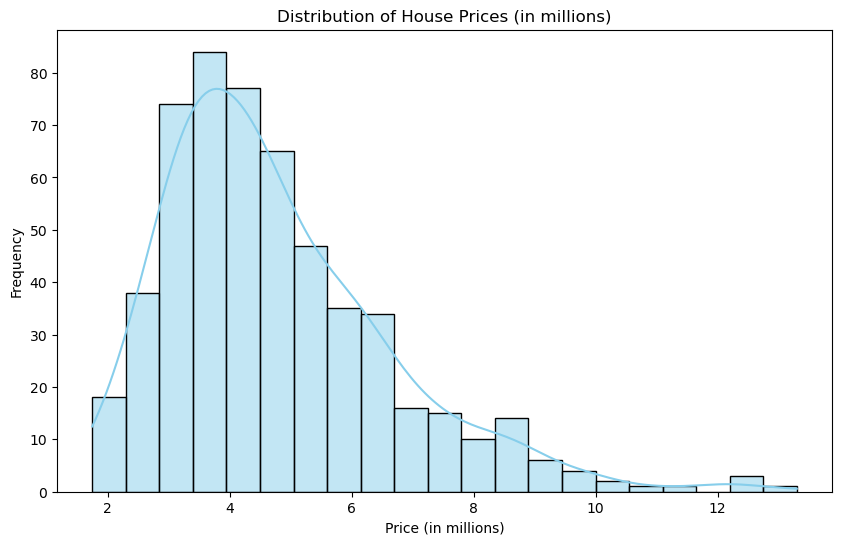

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6)) # kde: kernal density estimation
sns.histplot(df["price_millions"], kde=True, color="skyblue", edgecolor="black")
plt.title("Distribution of House Prices (in millions)")
plt.xlabel("Price (in millions)")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Preprocess
X, y, scaler_X, scaler_y = preprocess_data(df)
print("Data has been preprocessed. Feature matrix shape:", X.shape)

Data has been preprocessed. Feature matrix shape: (545, 12)


In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50)

In [10]:
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 436
Test set size: 109


In [11]:
# neural network model funtion
def build_model(input_dim, learning_rate=0.001):
    model = Sequential(
        [
            Dense(64, activation="relu", input_dim=input_dim),
            Dropout(0.2),
            Dense(32, activation="relu"),
            Dropout(0.2),
            Dense(16, activation="relu"),
            Dense(1, activation="linear"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model

In [ ]:
# hyperparameter
input_dim = X_train.shape[1]
learning_rate = 0.001  
epochs = 100           
batch_size = 16        

model = build_model(input_dim, learning_rate)
model.summary()

c:\Users\acer\anaconda3\envs\tensorflowgpu\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [14]:
# training 
print("Training the model...")
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1,
)
print("Training completed!")

Training the model...
Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2381 - mae: 0.4173 - val_loss: 0.0462 - val_mae: 0.1718
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0508 - mae: 0.1643 - val_loss: 0.0218 - val_mae: 0.1068
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - mae: 0.1210 - val_loss: 0.0150 - val_mae: 0.0871
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - mae: 0.1157 - val_loss: 0.0138 - val_mae: 0.0836
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mae: 0.1136 - val_loss: 0.0128 - val_mae: 0.0796
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - mae: 0.0997 - val_loss: 0.0119 - val_mae: 0.0771
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mae: 0.0958 - val_loss: 0.0113 - val_mae: 0.0744
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - mae: 0.1079 - val_loss: 0.0107 - val_mae: 0.0728
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 

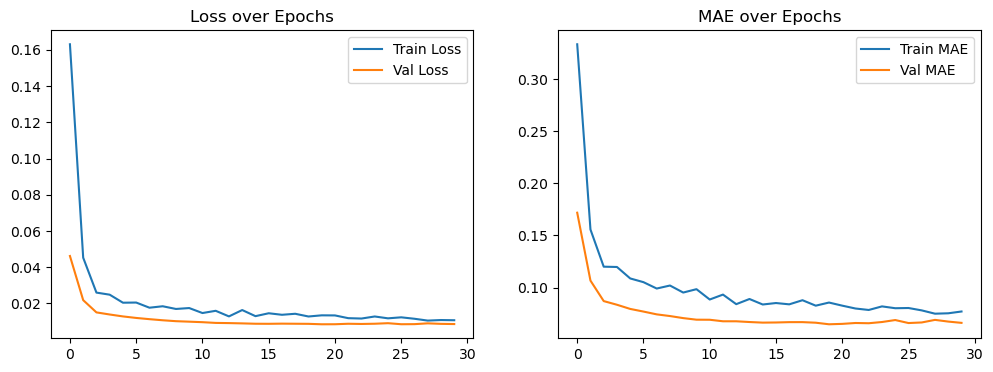

In [ ]:
# training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="Train Loss")
ax1.plot(history.history["val_loss"], label="Val Loss")
ax1.set_title("Loss over Epochs")
ax1.legend()

ax2.plot(history.history["mae"], label="Train MAE")
ax2.plot(history.history["val_mae"], label="Val MAE")
ax2.set_title("MAE over Epochs")
ax2.legend()

plt.show()

In [ ]:
# Predict 
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [17]:
# evaluation
r2 = r2_score(y_true, y_pred)
mae_val = mean_absolute_error(y_true, y_pred)
mse_val = mean_squared_error(y_true, y_pred)
rmse_val = np.sqrt(mse_val)

print("### Evaluation on Test Set")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae_val:.4f}")
print(f"Mean Squared Error: {mse_val:.4f}")
print(f"Root Mean Squared Error: {rmse_val:.4f}")

### Evaluation on Test Set
R² Score: 0.7218
Mean Absolute Error: 0.7682
Mean Squared Error: 0.9462
Root Mean Squared Error: 0.9727


In [19]:
# saving
model.save("tf_housing_model.h5")
joblib.dump(scaler_X, "scaler_X.pkl") 
joblib.dump(scaler_y, "scaler_y.pkl")
print("Model, scalers, and feature order have been saved!")

Model, scalers, and feature order have been saved!


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Actual House Price: $5.60M
Predicted House Price: $5.63M
Error Margin: $0.03 (0.55%)


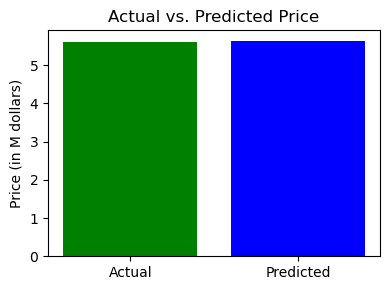

In [31]:
import random
# entire test set pred
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# randomly select
sample_index = random.choice(range(len(X_test)))

actual_price = y_true[sample_index][0]
predicted_price = y_pred[sample_index][0]

error_margin = abs(actual_price - predicted_price)
percent_error = (error_margin / actual_price) * 100 if actual_price != 0 else 0

print(f"Actual House Price: ${actual_price:,.2f}M")
print(f"Predicted House Price: ${predicted_price:,.2f}M")
print(f"Error Margin: ${error_margin:,.2f} ({percent_error:.2f}%)")

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(["Actual", "Predicted"], [actual_price, predicted_price], color=["green", "blue"])
ax.set_ylabel("Price (in M dollars)")
ax.set_title("Actual vs. Predicted Price")
plt.tight_layout()
plt.show()